In [1]:
# Import python packages that are used here
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, glob
import cmath as cm
from scipy.optimize import least_squares
from scipy.optimize import curve_fit
from glob import glob
from matplotlib.pyplot import figure
import os
import sys
import skrf as rf
import matlab.engine
import numpy as np
import matplotlib as mpl
# add %matplotlib widget to make plots interactive
%matplotlib widget
mpl.style.use('seaborn')
mpl.style.use('seaborn-muted')


In [2]:
# Modified BVD model excluding the admittance Ya(omega) but including the series inductive lump elements
def modified_BVD_model_background(freq, Ls, Rs, Rp, Cp):
    N = len(freq)
    freq = freq[: N//2]
    jOmega = 1j*2*np.pi*np.array(freq)

    # Refer the circuit model to the reference paper: (doi/10.1002/adma.202305434)

    Ls = Ls*1e-9 

    Cp= Cp*1e-9 
    
    Zp =  1/(jOmega*Cp + 1/Rp)
    return jOmega * Ls + Rs + Zp 

def modified_BVD_model_resonance(freq, Lm, Cm, Rm):
    # Convert the unit to SI unit 
    # Cm = Cm*1e-14 #F
    Cm = Cm*1e-9 #F
    Lm = Lm*1e-9 #H
    
    # Calculate the angular frequency
    Omega = 2*np.pi*np.array(freq) #Rad
    ws = 1/np.sqrt(Lm*Cm) #Rad/s

    # Calculate the admittance Ya
    Y = ( Rm * (Omega * Cm)**2 - 1j * Omega * Cm * ( (Omega/ws)**2 - 1) ) / ( (Rm * Omega * Cm)**2 + ((Omega/ws)**2 - 1)**2 )
    return Y # Is a complex number

In [3]:
a = np.array([1+1j, 2, 3])
a2 = np.array([1+1j, 2, 3])
b = 1
c = b/a
print(a * a)
print(a * a + 1)
print(3 / (a * a + 1))

[0.+2.j 4.+0.j 9.+0.j]
[ 1.+2.j  5.+0.j 10.+0.j]
[0.6-1.2j 0.6+0.j  0.3+0.j ]


In [4]:
def hstack_BVD_for_fit(Z):
    return np.hstack((Z.real, Z.imag))

def modified_BVD_model_background2(freq, Ls, Rs, Rp, Cp, stack=True):
    N = len(freq)
    freq = freq[: N//2]
    Ls = Ls*1e-9 
    Cp= Cp*1e-9 
    Omega = freq * 2 * np.pi
    # v1 = Rs
    # v2 = Rp
    # v3 = Cp
    # v4 = Ls
    # Z_real = v1 + v2/(1+np.square(xdata*v2*v3))
    Z_imag = -(Omega*np.square(Rp)*Cp) / (1+np.square(Omega*Rp*Cp)) + Omega*Ls
    Z_real = (Rp / (1 + np.square(Omega * Cp * Rp))) + Rs
    # print('debug')
    # print(Omega * Cp * Rp)
    # print(np.square(Omega * Cp * Rp))
    # print(1 + np.square(Omega * Cp * Rp))
    # print(Rp / (1 + np.square(Omega * Cp * Rp)))
    # print(Z_real.shape)
    # print(Z_imag.shape)
    # Z_abs = np.abs(Z_real + Z_imag)
    # return Z_real + Z_imag * 1j, Z_real, Z_imag
    if stack is False:
        return Z_real + Z_imag * 1j
    else:
        return np.hstack((Z_real, Z_imag))

# Convert the S11 data to impedance
def convert_s11_to_impedance(s11_pol):
    s11_pol = np.array(s11_pol)
    imp_pol = 50 * (1+s11_pol) / (1-s11_pol)
    return imp_pol

# Covert the fitted load to S11 data
def convert_imped_to_s11(impedance):
    impedance = np.array(impedance)
    s11_pol = (impedance - 50) / (impedance + 50)
    return s11_pol

def fit_BVD_model_background(freq, Impedance_data, start1, end1, start2, end2, p0, bounds, ftol, max_nfev,
                                
                                print_params = True, plot_fit=False, s11_pol=None, BG_fit_params_manual=None):

    # Find the indices of the range in xdata
    start_idx1 = np.argmin(np.abs(freq - start1))
    end_idx1 = np.argmin(np.abs(freq - end1))
    start_idx2 = np.argmin(np.abs(freq - start2))
    end_idx2 = np.argmin(np.abs(freq - end2))



    # print('freq is: ', freq)
    # print('start1: ', start1)
    # print('temp: ', freq - start1)
    # print('diff: ', start_idx1)

    # print('DEBUGGING: ')
    # print(freq[start_idx1])
    # print(freq[end_idx1])
    # print(freq[start_idx2])
    # print(freq[end_idx2])
    # Slice xdata and ydata to the two specified ranges and concatenate them
    x_fit_full = freq[start_idx1: end_idx2]
    # print('x_fit full shape', x_fit_full.shape)
    # print(freq[start_idx1])
    # print(freq[end_idx2])
    y_fit_smoothened = np.linspace(Impedance_data[end_idx1], Impedance_data[start_idx2], start_idx2 - end_idx1)
    # print('y_fit smoothened', y_fit_smoothened.shape)
    y_fit_full = np.concatenate((Impedance_data[start_idx1:end_idx1], y_fit_smoothened, Impedance_data[start_idx2:end_idx2])) 
    # print('y_fit full shape', y_fit_full.shape)
    x_fit = np.concatenate((freq[start_idx1:end_idx1+1], freq[start_idx2:end_idx2+1]))
    y_fit = np.concatenate((Impedance_data[start_idx1:end_idx1+1], Impedance_data[start_idx2:end_idx2+1]))
    y_fit_full_stacked = np.hstack((y_fit_full.real, y_fit_full.imag))
    # print('y_fit_full_stack shape', y_fit_full_stacked.shape)
    x_fit_full_stacked = np.hstack((x_fit_full.real, x_fit_full.imag))
    # print('x_fit_full_stack shape', x_fit_full_stacked.shape)
    # print('xy_fit shape:')
    # print(x_fit.shape)
    # print(y_fit.shape)
    # y_fit_stacked = np.hstack((y_fit.real, y_fit.imag))
    # print(y_fit_stacked.shape)
    # print(np.hstack((y_fit.real, y_fit.imag).shape))

    x_stack = np.hstack((x_fit, x_fit))
    y_stack = np.hstack((y_fit.real, y_fit.imag))
    # print('x stack: ', x_stack.shape)
    # print('y stack: ', y_stack.shape)
    # Perform fitting
    # popt, _, = curve_fit(lambda freq, Ls, Rs, Rp, Cp:
    #                     hstack_BVD_for_fit(modified_BVD_model_background(freq, Ls, Rs, Rp, Cp)),
    #                     np.hstack((x_fit, x_fit)),
    #                     np.hstack((y_fit.real, y_fit.imag)),
    #                     p0= p0,
    #                     bounds = bounds
    #                     )
    # plt.plot(freq, y_fit_full.real)
    # plt.plot(freq, y_fit_full.imag)
        # Perform fitting
    # popt, _, = curve_fit(lambda freq, Ls, Rs, Rp, Cp:
    #                     hstack_BVD_for_fit(modified_BVD_model_background(freq, Ls, Rs, Rp, Cp)),
    #                     x_fit_full_stacked,
    #                     y_fit_full_stacked,
    #                     p0= p0,
    #                     # bounds = bounds,
    #                     ftol=1e-8
    #                     )
    popt, _, = curve_fit(lambda freq, Ls, Rs, Rp, Cp:
                    modified_BVD_model_background2(freq, Ls, Rs, Rp, Cp),
                    x_fit_full_stacked,
                    y_fit_full_stacked,
                    p0= p0,
                    # bounds = bounds,
                    ftol=1e-6
                    )

    Ls, Rs, Rp, Cp = popt[0], popt[1], popt[2], popt[3] 
    if BG_fit_params_manual is not None:
        Ls, Rs, Rp, Cp = BG_fit_params_manual[0], BG_fit_params_manual[1], BG_fit_params_manual[2], BG_fit_params_manual[3] 
    
    if print_params == True:
        print('Ls =', popt[0], 'nH')
        print('Rs =', popt[1], 'Ohm')
        print('Rp =', popt[2], 'Ohm')
        print('Cp =', popt[3], 'nF')
        print(_)
        
    imped_fit = modified_BVD_model_background(np.hstack((freq, freq)), Ls, Rs, Rp, Cp)
    imped_fit = modified_BVD_model_background2(np.hstack((freq, freq)), Ls, Rs, Rp, Cp, stack=False)
    s11_fit = convert_imped_to_s11(imped_fit)
    # print('zreal')
    # print(Z_real.shape)
    # print(Z_real)
    # print(freq.shape)
    # print(s11_fit.shape)
    if plot_fit:
        plt.figure(figsize=(8, 4))
        plt.plot(freq, abs(s11_pol))
        plt.plot(freq, abs(s11_fit))
        plt.xlabel('Frequency (GHz)')
        plt.ylabel('|S11|')
        plt.legend(['measured', 'fitted'])
        plt.title('S11 fitting')
        plt.show()
        plt.figure(figsize=(8, 4))
        plt.suptitle('S11 fitting subplots')
        plt.subplot(2, 2, 1)
        plt.plot(freq, Impedance_data.real)
        plt.plot(freq, imped_fit.real)
        plt.xlabel('Frequency (GHz)')
        plt.ylabel('Real(Impedance)')
        plt.legend(['measured', 'fitted'])
        plt.subplot(2, 2, 2)
        plt.plot(freq, Impedance_data.imag)
        plt.plot(freq, imped_fit.imag)
        plt.xlabel('Frequency (GHz)')
        plt.ylabel('Imag(Impedance)')
        plt.legend(['measured', 'fitted'])
        plt.subplot(2, 2, 3)
        plt.plot(freq, s11_pol.real)
        plt.plot(freq, s11_fit.real)
        plt.xlabel('Frequency (GHz)')
        plt.ylabel('Imag(S11)')
        plt.legend(['measured', 'fitted'])
        plt.subplot(2, 2, 4)
        plt.plot(freq, s11_pol.imag)
        plt.plot(freq, s11_fit.imag)
        plt.xlabel('Frequency (GHz)')
        plt.ylabel('Imag(S11)')
        plt.legend(['measured', 'fitted'])
        plt.tight_layout()

    return s11_fit, imped_fit, popt



In [5]:
def modified_BVD_model_resonance2(freq, Lm, Cm, Rm, stack=True):
    # print('Debug resonance2 model')
    # print(Lm)
    # print(Rm)
    # print(Cm)
    N = len(freq)
    freq = freq[: N//2]
    Lm = Lm*1e-9 
    Cm = Cm*1e-9 
    Omega = freq * 2 * np.pi

    Y_real = Rm / (np.square(Rm) + np.square(Omega * Lm - 1 / (Omega * Cm)))
    Y_imag  = -(Omega * Lm - 1 / (Omega * Cm)) / (np.square(Rm) + np.square(Omega * Lm - 1 / (Omega * Cm)))

    # Y_f = 1 / (Rm + 1j * Omega * Lm - 1j / (Omega * Cm))
    # print('debug')
    # print(Omega * Cp * Rp)
    # print(np.square(Omega * Cp * Rp))
    # print(1 + np.square(Omega * Cp * Rp))
    # print(Rp / (1 + np.square(Omega * Cp * Rp)))
    # print(Z_real.shape)
    # print(Z_imag.shape)
    # Z_abs = np.abs(Z_real + Z_imag)
    # return Z_real + Z_imag * 1j, Z_real, Z_imag
    if stack is False:
        return Y_real + Y_imag * 1j
        # print(Y_f.shape)
        # plt.figure()
        # plt.plot(freq, Y_f)
        # return Y_f
    else:
        return np.hstack((Y_real, Y_imag))

def fit_BVD_model_resonances(freq, Impedance_data,
                            start1, end1, start2, end2,
                            p0, bounds, ftol, bg_params = [0.17, 4.13, 34.19, 3.14e-3], print_params = True, 
                            Lm=4.65506298e-01, Cm=5.00635523e-02, Rm=8.01179481e-08, manual_fitting = True, plot_fit = True):
    # Lm = Lm*1e-9 
    # Cm = Cm*1e-9 
    
    # Rm0 = 1 / np.max(Admittance_data_fit.real)
    # Lm0 = Rm0 * 
    # Find the indices of the range in xdata
    start_idx1 = np.argmin(np.abs(freq - start1))
    end_idx1 = np.argmin(np.abs(freq - end1))
    start_idx2 = np.argmin(np.abs(freq - start2))
    end_idx2 = np.argmin(np.abs(freq - end2))
    Ls, Rs, Rp, Cp = bg_params[0] * 1e-9, bg_params[1], bg_params[2], (bg_params[3]) * 1e-9
    # Slice xdata and ydata to the two specified ranges and concatenate them
    # Freq_fit = np.concatenate((freq[start_idx1:end_idx1 + 1], freq[start_idx2:end_idx2 + 1]))
    # Admittance_fit = 1/np.concatenate((Impedance_data[start_idx1:end_idx1 + 1], Impedance_data[start_idx2:end_idx2 + 1]))
    Admittance_data = 1 / (Impedance_data - Rs - 1j*Ls*freq*2*np.pi) - (1/Rp + 1j*Cp*freq*2*np.pi)
    freq_fit = freq[start_idx1:end_idx2]
    Admittance_data_fit = Admittance_data[start_idx1:end_idx2]
    freq_fit_stacked = np.hstack((freq_fit, freq_fit))
    Admittance_data_fit_stacked = np.hstack((Admittance_data_fit.real, Admittance_data_fit.imag))
    # find dip/peak position
    w_r = freq_fit[np.argmax(Admittance_data_fit.real)] * 2 * np.pi
    w_l = freq_fit[np.argmin(Admittance_data_fit.imag)] * 2 * np.pi
    print(w_r)
    print(w_l)
    Rm0 = 1 / np.max(Admittance_data_fit.real) 
    Lm0 = Rm0 * w_l  / (w_l**2 - w_r**2)
    Cm0 = 1 / Lm0 / (w_r**2)
    Lm0 = Lm0 * 1e9
    Cm0 = Cm0 * 1e9
    print('initial guesses')

    print(Lm0)
    print(Cm0)
    print(Rm0)
    p0 = [Lm0, Cm0, Rm0]

    # plt.figure()
    # plt.plot(freq_fit, Admittance_data_fit.real)
    # plt.figure()
    # plt.plot(freq_fit, Admittance_data_fit.imag)

    # # Rs, R0, and C0 units are Ohm, Ohm, and nF. 
    # L0, Rs, R0, C0 = bg_params[0]*1e-9, bg_params[1]-1.1, bg_params[2], (bg_params[3]-1e-4)*1e-9
    
    def Z0_para(freq, Rp, Cp):
        Omega = 2*np.pi*np.array(freq) #Rad
        return np.array(1 / (1 / Rp + 1j * Omega * Cp))
    
    popt = None
    if manual_fitting is True:
        Lm, Cm, Rm = Lm, Cm, Rm
    else:
    # Perform fitting
        
        popt, _  = curve_fit(lambda freq, Lm, Cm, Rm:
                                modified_BVD_model_resonance2(freq, Lm, Cm, Rm),       
                                freq_fit_stacked,
                                Admittance_data_fit_stacked,
                                p0= p0,
                                bounds = bounds,
                                ftol=1e-12,
                            )
        # Assign the fitted parameters
        Lm, Cm, Rm = popt[0], popt[1], popt[2]

    # Calculate the admittance of the 4 resonances
    Omega = 2 * np.pi * np.array(freq)
    print('Debug resonances')
    print('Lm', Lm)
    print('Cm', Cm)
    print('Rm', Rm)
    Y_fit = modified_BVD_model_resonance2(np.hstack((freq, freq)), Lm, Cm, Rm, stack=False)
    Z_tot_fit = Rs + 1j * Omega * Ls  + 1 / (1/Rp + 1j * Omega * Cp + Y_fit)

    # Convert impedance to s11
    s11_fit = convert_imped_to_s11(Z_tot_fit)
    s11_pol = convert_imped_to_s11(Impedance_data)
    if plot_fit:
        plt.figure(figsize=(12, 4))
        plt.suptitle('S11 Fitting')
        plt.subplot2grid((2, 4), (0, 0), colspan=2, rowspan=2)
        plt.plot(freq, abs(s11_pol))
        plt.plot(freq, abs(s11_fit), linestyle='dashed')
        plt.xlabel('Frequency')
        plt.ylabel('|S11|')
        plt.legend(['measured', 'fitted'])
        # plt.title('S11 fitting')
        # plt.show()
        # plt.figure(figsize=(8, 4))
        
        plt.subplot2grid((2, 4), (0, 2))
        plt.plot(freq, s11_pol.real)
        plt.plot(freq, s11_fit.real, linestyle='dashed')
        plt.xlabel('Frequency')
        plt.ylabel('Real(S11)')
        plt.legend(['measured', 'fitted'])
        plt.subplot2grid((2, 4), (1, 2))
        plt.plot(freq, s11_pol.imag)
        plt.plot(freq, s11_fit.imag, linestyle='dashed')
        plt.xlabel('Frequency')
        plt.ylabel('Imag(Sqq)')
        plt.legend(['measured', 'fitted'])
        plt.tight_layout()

        plt.subplot2grid((2, 4), (0, 3))
        plt.plot(freq, Admittance_data.real)
        plt.plot(freq, Y_fit.real)
        plt.xlabel('Frequency (GHz)')
        plt.ylabel('Imag(Y)')
        plt.legend(['measured', 'fitted'])
        plt.xlim(start1, end2)
        plt.subplot2grid((2, 4), (1, 3))
        plt.plot(freq, Admittance_data.imag)
        plt.plot(freq, Y_fit.imag)
        plt.xlabel('Frequency (GHz)')
        plt.ylabel('Imag(Y)')
        plt.legend(['measured', 'fitted'])
        plt.xlim(start1, end2)
        plt.tight_layout()


    
    if print_params == True:
        print(popt)
    
    return s11_fit, Z_tot_fit, popt, Y_fit

In [6]:
def plot_fit(freq, Impedance_data, imped_fit, s11_pol, s11_fit):
    # fig = plt.figure(figsize=(12,5))
    # fig = plt.figure(4)
    plt.figure()
    ax1 = plt.subplot(221)
    ax2 = plt.subplot(222)
    ax3 = plt.subplot(223)
    ax4 = plt.subplot(224)

    ax1.plot(freq, Impedance_data.real, label = 'data_real')
    ax1.plot(freq, (imped_fit).real, label = 'fit_real')
    ax1.plot(freq, Impedance_data.imag, label = 'data_imag')
    ax1.plot(freq, (imped_fit).imag, label = 'fit_imag')
    # ax1.set_xlim(0.71*10**9, 0.73*10**9)
    # ax1.set_ylim(-10, 10)

    ax2.plot(freq, abs(Impedance_data), label ='real Z_0 data abs')
    ax2.plot(freq, abs(imped_fit), label ='fitted Z_0 data abs')
    # ax2.set_xlim(0.71*10**9, 0.73*10**9)
    # ax2.set_ylim(-10, 10)

    ax3.plot(freq, s11_pol.real, label = 'data_real')
    ax3.plot(freq, (s11_fit).real, label = 'fit_real')
    ax3.plot(freq, s11_pol.imag, label = 'data_imag')
    ax3.plot(freq, (s11_fit).imag, label = 'fit_imag')
    # ax3.set_xlim(0.71*10**9, 0.73*10**9)
    # ax3.set_ylim(-10, 10)

    ax4.plot(freq, abs(s11_pol), label ='real s11 data abs')
    ax4.plot(freq, abs(s11_fit), label ='fitted s11 data abs')
    # ax4.set_xlim(0, 0.15*10**10)
    # ax4.set_ylim(0.8, 1)
    # ax4.set_xlim(0.7*10**9, 0.8*10**9)
    # ax4.set_ylim(0.8, 1.2)

    # fig.tight_layout()

First, we load the files 'B0.s2p‘ into B0_4K variable, from which we extract normalized s11_pol (polar form of S11) and freq. The plot is automatically interactive since we add %matplotlib widget at the beginning of the notebook, which allows us to drag and zoom in & out.

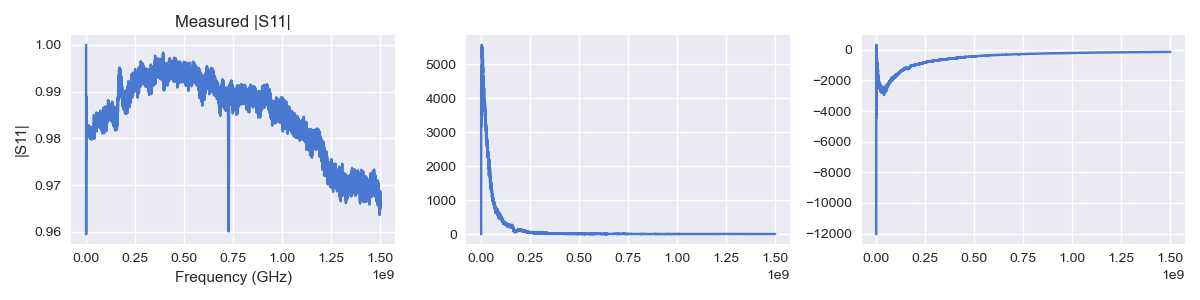

In [7]:

plt.figure(figsize=(12, 3))
file_name = 'B0.s2p'
B0_4K = rf.Network(file_name)
s11_pol = B0_4K.s[:,0,0]
max = np.max(np.absolute(s11_pol))
s11_pol = s11_pol / max
freq = B0_4K.f
Impedance_data = convert_s11_to_impedance(s11_pol)
plt.subplot(1, 3, 1)
plt.plot(freq, np.absolute(s11_pol))
plt.xlabel('Frequency (GHz)')
plt.ylabel('|S11|')
# plt.legend()
plt.title(label='Measured |S11|')
plt.subplot(1, 3, 2)
plt.plot(freq, Impedance_data.real)
plt.subplot(1, 3, 3)
plt.plot(freq, Impedance_data.imag)
plt.tight_layout()
# plt.show()
# plt.title('S11 Fitting')
# plt.grid()


From the normalized |S11| plot, we can define the range of frequency to extract background with two endpoints start_bg, end_bg. we can also define the range of frequency to extract resonance with two endpoints start_reso, end_reso.

In [8]:
start_bg, end_bg = 0.3e9, 0.71e9
start_bg2, end_bg2 = 0.73e9, 1.5e9
start_reso, end_reso = 0.71e9, 0.725e9
start_reso2, end_reso2 = 0.725e9, 0.73e9

We first fit the background. Background is determined by Ls, Rs, Rp, Cp. To do the fitting, we convert s11_pol to impedance, then fit the impedance with Ls, Rs, Rp, Cp with the formula.

Ls = 1.8307774522734517 nH
Rs = 4.543822783969003 Ohm
Rp = 20274.85823838552 Ohm
Cp = 0.0007392975576717832 nF
[[ 6.25308072e-05 -8.34299878e-06  8.34442438e-06 -6.07882696e-10]
 [-8.34299878e-06  2.29666798e-03  4.43318842e+00  2.48504150e-10]
 [ 8.34442438e-06  4.43318842e+00  1.77046836e+04  3.23199857e-07]
 [-6.07882696e-10  2.48504150e-10  3.23199857e-07  1.22126764e-14]]
4570103484.502072
4575757220.30518
initial guesses
301143.04555382417
1.5899193438315427e-07
3403.0627511626944
Debug resonances
Lm 301143.04555382417
Cm 1.5899193438315427e-07
Rm 3849.8052
[3.01143046e+05 1.58991934e-07 3.84980520e+03]


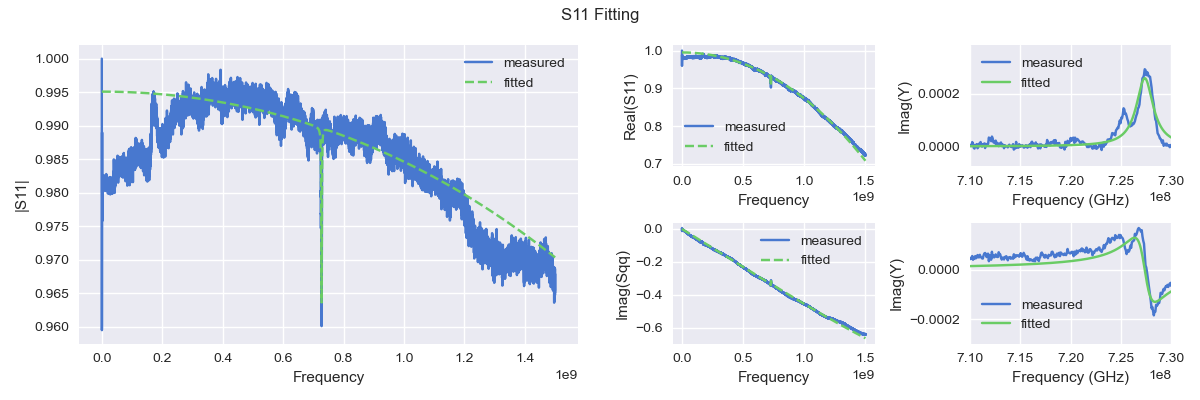

In [9]:
# initial guess of parameters
# p0_bg = [1.7877, 4.7303, 12239.0122, 0.00073983] # LS, RS, RP, CP
p0_bg = [0.8, 1e-6, 2000, 1e-3] # LS, RS, RP, CP
p0_reso = [301441, 1.59e-7, 3406] # Lm, Cm, Rm
# Set bounds on the parameters
bounds_bg = ((0, 0, 0, 0), (np.inf, np.inf, np.inf, np.inf)) # Ls, Rs, Rp. Cp
# bounds_reso = ((0, 0, 0), (800000, 30, 5000)) # Lm, Cm, Rm
bounds_reso = ((0, 0, 0), (np.inf, np.inf, np.inf)) # Lm, Cm, Rm
# Set tolerance
ftol = 1e-6
max_nfev = 1e10
BG_fit_params_manual = [1.8031, 4.6535, 14544.0122, 0.00073983]
BG_fit_params_manual = [1.7877, 4.7307, 12239.996, 0.00073991] 

# Conver s11_pol to impedance
Impedance_data = convert_s11_to_impedance(s11_pol)
_, _, BG_fit_params = fit_BVD_model_background(freq, Impedance_data, start_bg, end_bg, start_bg2, end_bg2, 
                                                p0_bg, bounds_bg, ftol, max_nfev, 
                                                plot_fit=False, s11_pol=s11_pol, 
                                                BG_fit_params_manual=BG_fit_params_manual)
# [Ls, Rs, Rp, Cp] = BG_fit_params
s11_fit, Z_total, popt, Y_list   = fit_BVD_model_resonances(freq, Impedance_data,
                                                                start_reso, end_reso, start_reso2, end_reso2,
                                                                p0_reso, bounds_reso, ftol=1e-6, bg_params = BG_fit_params, print_params = True,
                                                                Lm=340675.8359,
                                                                Cm=1.4054e-07,
                                                                Rm=3849.8052,
                                                                manual_fitting=False,
                                                                plot_fit=True
                                                            )

In [10]:
# import importlib
# import bvd_library
# importlib.reload(bvd_library)
# from bvd_library import *
# c = add(1, 2)
# print(c)
# plt.close('all')
# fig = plt.figure()

# plt.subplot2grid((3, 3), (0, 0))
# plt.subplot2grid((3, 3), (0, 1), colspan=2)
# plt.subplot2grid((3, 3), (1, 0), colspan=2, rowspan=2)
# plt.subplot2grid((3, 3), (1, 2), rowspan=2)
# plt.tight_layout()


In [11]:
# eng = matlab.engine.start_matlab()
# Rs, Ls, Rl, Ce, Rm, Cm, Lm = eng.S11_Fitting_RLC('B0.s2p', nargout=7)

In [12]:
# Y_data_normalized = 1 / (Impedance_data - Rs - )

In [13]:
# %matplotlib widget
# plt.clf()
# plt.figure(1)
file_name = ['4K/B0.s2p', 'RT/B0.s2p', '4K/B4.s2p', 'RT/B1.s2p', '', '', '', 'alscn_1p2um.s2p']
B0_4K = rf.Network(file_name[0])
B0_RT = rf.Network(file_name[0])


# Load the data from the imported network in skrf
s11_pol = B0_RT.s[:,0,0]
# Normalize s11_pol:
print('before normalization: abs: ')
print(np.max(np.absolute(s11_pol)))
max = np.max(np.absolute(s11_pol))
s11_pol = s11_pol / max
# print(s11_pol)
print('after normalization: abs: ')
print(np.max(np.absolute(s11_pol)))
freq = B0_RT.f
plot = True

# Define the fitting range (for 4K)
start_bg, end_bg = 0.3e9, 0.71e9 #Hz
start_bg2, end_bg2 = 0.74e9, 1.5e9
start_reso, end_reso = 0.725e9, 0.726e9
start_reso2, end_reso2 = 0.726e9, 0.730e9
# Define the fitting range (for RT)
start_bg, end_bg = 0.2e9, 0.6e9 #Hz
start_bg2, end_bg2 = 0.8e9, 1.4e9
start_reso, end_reso = 0.72e9, 0.725e9
start_reso2, end_reso2 = 0.725e9, 0.73e9

# Define the initial fitting params
# p0_bg = [0.2, 1e-6, 500, 1e-2]
# p0_bg = [0.2, 1e-6, 500, 1e-2]
p0_bg = [0.8, 4e-6, 2000, 4e-2]
p0_bg = [6.4, 5.99, 27963, 0.00478]
p0_bg = [1.8031, 4.6535, 14544.0122, 0.00073983] 
p0_bg = [1.7877, 4.7303, 12239.0122, 0.00073983] # LS, RS, RP, CP
# p0_reso = [10, 1, 1000] # Lm, Cm, Rm
p0_reso = [10, 1, 1000] # Lm, Cm, Rm
# try new parameters
p0_reso = [301441, 1.59e-7, 3406] # Lm, Cm, Rm
# p0_reso = [300000, 2e-7, 3000] # Lm, Cm, Rm

# Set bounds on the parameters
# bounds_bg = ((1e-2, 1e-10, 0, 1e-5), (200, np.inf, np.inf, 10)) # Ls, Rs, Rp. Cp
bounds_bg = ((1e-2, 1e-10, 0, 1e-5), (200, np.inf, np.inf, 10)) # Ls, Rs, Rp. Cp
bounds_bg = ((0, 0, 0, 0), (np.inf, np.inf, np.inf, np.inf)) # Ls, Rs, Rp. Cp
bounds_reso = ((0, 0, 0), (800000, 30, 5000)) # Lm, Cm, Rm

# Set tolerance
ftol = 1e-6
max_nfev = 1e10

# Actual fitting functions below
Impedance_data = convert_s11_to_impedance(s11_pol)

# try:
BG_fit_params_manual = [6.4, 5.99, 27963, 0.00478] 
BG_fit_params_manual = [1.8031, 4.6535, 14544.0122, 0.00073983] 
_, _, BG_fit_params = fit_BVD_model_background(freq, Impedance_data, start_bg, end_bg, start_bg2, end_bg2, 
                                                p0_bg, bounds_bg, ftol, max_nfev, 
                                                plot_fit=True, s11_pol=s11_pol, 
                                                BG_fit_params_manual=None)
BG_fit_params_copy = BG_fit_params
s11_fit, Z_total, popt, Y_list   = fit_BVD_model_resonances(freq, Impedance_data,
                                                                start_reso, end_reso, start_reso2, end_reso2,
                                                                p0_reso, bounds_reso, ftol=1e-6, bg_params = BG_fit_params_manual, print_params = True,
                                                                Lm=1000,
                                                                Cm=10,
                                                                Rm=1e-5,
                                                                manual_fitting=False
                                                                )

# BG_fit_params_manual = [6.4, 5.99, 27963, 0.00478] 
# BG_fit_params_manual = [1.8031, 4.6535, 14544.0122, 0.00073983] 
# # 'Rs = 4.6535 ohm, Ls = 1.8031 nH, Rl = 14544.0122 ohm, Cl = 0.00073983 nF'
# s11_fit, Z_total, popt, Y_list   = fit_BVD_model_resonances(np.stack((freq, freq)), Impedance_data,
#                                                                 start_reso, end_reso, start_reso2, end_reso2,
#                                                                 p0_reso, bounds_reso, ftol=0, 
#                                                                 bg_params = BG_fit_params, print_params = True,
#                                                                 Lm=301441,
#                                                                 Cm=1.59e-7,
#                                                                 Rm=3406,
#                                                                 manual_fitting=False
#                                                                 )
# print('resonance params')
# print(popt)

# if plot == True:
#     plot_fit(freq, Impedance_data, Z_total, s11_pol, s11_fit)

# except:
#     print('Fit failed')
# plt.show(block=True)

FileNotFoundError: [Errno 2] No such file or directory: '4K/B0.s2p'

In [ ]:
# print(BG_fit_params)
# #Fit_params_4K = [0.1e-1, 6, 0.6e2, 1.5e-3]

# # Generate some example frequency
# Y3 = modified_BVD_model_resonance(freq, Lm=0.01, Cm=0.8, Rm=1) # Signal at 4.8 GHz

# # Calculate Z0
# jOmega = 1j * 2 * np.pi * freq
# Ls, Rs, Rp, Cp = BG_fit_params[0] * 1e-9, BG_fit_params[1], BG_fit_params[2], (BG_fit_params[3]) * 1e-9 
# Z0 = np.array(1/(1 / Rp + jOmega * Cp)) 

# # Calculate the N combined admittances
# Y_N = Y3

# # Calculate the total impedance
# Z_total = jOmega * Ls + Rs + 1/(1/Z0 + Y_N)  

# # Calculate the total impedance
# Y_total = 1 / Z_total 

# # Calculate the S11 from total impedance
# s11_fit = convert_imped_to_s11(Z_total)

# # Plot the fitted admittance and the S11
# plot_fit(freq, Impedance_data, Z_total, s11_pol, s11_fit)

# #Save the variables for supporting figures
# freq_sup = freq
# Z_sup = Impedance_data
# Z_fit_sup = Z_total
# S11_data_sup = s11_pol
# S11_fit_sup = s11_fit

# Time-domain analysis

In [ ]:
root_path = r'/Users/itungchen/UW_lab_data/'
dir_name =  root_path + '/20231206-AlScN-SOS//'

# Define the sort function of the frequency domain data
def sortdata(s):
    return int(os.path.basename(s)[1:-4])

B_data_list = glob('4K/C*.s2p')
B_data_list.sort(key = sortdata)

# Load the data to netowrk list
B_ntwk_list = []
for B in B_data_list:
    B_ntwk_list.append(rf.Network(B))

In [ ]:
fig = plt.figure(figsize=(8,5))
ax1 = plt.subplot(111)

for i in range(len(B_ntwk_list)):
    B_ntwk_list[i].s21.plot_s_time_db(label=i, ax = ax1)

ax1.set_xlim(-500,2000)
ax1.set_ylabel('S21 (dB)')

In [ ]:
fig = plt.figure(figsize=(8,5))
ax1 = plt.subplot(111)

for i in range(len(B_ntwk_list)):
    B_ntwk_list[i].frequency.unit = 'mhz'
    B_ntwk_list[i].s21['500-850mhz'].plot_s_db(label=i, ax = ax1)

ax1.set_ylabel('S21 (dB)')

In [ ]:
# Perform time-gating on each nework data
B_ntwk_list_gate = []
for i in range(len(B_ntwk_list)):
    B_ntwk_list_gate.append(rf.time.time_gate(B_ntwk_list[i].s21, 100, 2500, t_unit='ns', window = 'boxcar'))

fig = plt.figure(figsize=(8,3))
ax1 = plt.subplot(111)

for i in range(len(B_ntwk_list)):
    B_ntwk_list_gate[i].plot_s_time_db(label=i, ax = ax1)

ax1.set_xlim(0,2500)
ax1.set_ylabel('S21 (dB)')

In [ ]:
# Plot the time-gated data
fig = plt.figure(figsize=(8,5))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
for i in range(len(B_ntwk_list)):
    B_ntwk_list_gate[i]['700-750mhz'].plot_s_mag(label=i, ax = ax1)
    B_ntwk_list_gate[i]['700-750mhz'].plot_s_db(label=i, ax = ax2)

ax1.set_ylabel('S21 (Magnitude)')
ax2.set_ylabel('S21 (dB)')
fig.tight_layout()


In [ ]:
B_ntwk_list_gate[0].s[:,0,0]

In [ ]:
import scipy
scipy.signal.get_window(('boxcar'), 2000)

In [ ]:
fig = plt.figure(figsize=(8,5))
ax1 = plt.subplot(111)

for i in range(len(B_ntwk_list)):
    B_ntwk_list_gate[i].plot_s_time_db(label=i, ax = ax1)

ax1.set_xlim(-500,2500)
ax1.set_ylabel('S21 (dB)')

In [ ]:
# Plot the time-gated data
fig = plt.figure(figsize=(8,5))
ax1 = plt.subplot(111)
for i in range(len(B_ntwk_list)):
    B_ntwk_list_gate[i]['600-850mhz'].plot_s_db(label=i, ax = ax1)

